## Inicialización

In [2]:
#Importacion de librerias

import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [3]:
# Definir rutas de archivos
data_path = '/datasets/faces/'
labels_file = os.path.join(data_path, 'labels.csv')
image_folder = os.path.join(data_path, 'final_files/')

# Cargar etiquetas
labels = pd.read_csv(labels_file)

# Revisar el contenido del archivo CSV
print(labels.head())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [4]:
# Mostrar los nombres de las columnas del archivo CSV
print(labels.columns)


Index(['file_name', 'real_age'], dtype='object')


In [5]:
# Verificar la existencia del archivo CSV y la carpeta de imágenes
print(f"¿El archivo de etiquetas existe? {os.path.exists(labels_file)}")
print(f"¿La carpeta de imágenes existe? {os.path.exists(image_folder)}")

# Verificar que hay imágenes en la carpeta
image_files = os.listdir(image_folder)
print(f"Número de imágenes en la carpeta: {len(image_files)}")

# Mostrar los primeros 5 nombres de archivos de imágenes
print("Primeras 5 imágenes en la carpeta:")
print(image_files[:5])

# Verificar si las imágenes mencionadas en el archivo CSV están en la carpeta
csv_image_names = labels['file_name'].values  # Reemplazar 'image_names' por 'file_name'
missing_images = [img for img in csv_image_names if img not in image_files]

print(f"Número de imágenes en el CSV: {len(csv_image_names)}")
print(f"Imágenes que faltan en la carpeta de imágenes: {len(missing_images)}")

if len(missing_images) > 0:
    print("Imágenes que faltan en la carpeta de imágenes:")
    print(missing_images[:5])  # Mostrar las primeras 5 imágenes que faltan (si las hay)
else:
    print("Todas las imágenes del CSV están presentes en la carpeta.")



¿El archivo de etiquetas existe? True
¿La carpeta de imágenes existe? True
Número de imágenes en la carpeta: 7591
Primeras 5 imágenes en la carpeta:
['006902.jpg', '003356.jpg', '002627.jpg', '004085.jpg', '005138.jpg']
Número de imágenes en el CSV: 7591
Imágenes que faltan en la carpeta de imágenes: 0
Todas las imágenes del CSV están presentes en la carpeta.


In [6]:
# Crear el generador de datos
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)

# Crear el flujo de datos para entrenamiento
train_datagen_flow = datagen.flow_from_directory(
    image_folder,
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345
)

# Crear el flujo de datos para validación
val_datagen_flow = datagen.flow_from_directory(
    image_folder,
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345
)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [8]:
# Crear el flujo de datos para entrenamiento
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=image_folder,
    x_col='file_name',  # Nombre del archivo en el CSV
    y_col='real_age',   # Columna de etiquetas
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',   # Cambia a 'raw'
    subset='training',
    seed=12345
)

# Crear el flujo de datos para validación
val_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=image_folder,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',   # Cambia a 'raw'
    subset='validation',
    seed=12345
)


Found 5694 validated image filenames.
Found 1897 validated image filenames.


En la fase de preparación de datos para el modelo de aprendizaje automático, inicialmente se utilizó el método flow_from_directory de Keras para cargar las imágenes. Sin embargo, este enfoque no funcionó adecuadamente debido a la estructura de los archivos en el directorio de imágenes. El método flow_from_directory requiere que las imágenes estén organizadas en subcarpetas, cada una representando una clase específica.

Dado que en nuestro caso todas las imágenes estaban en un solo directorio sin subcarpetas, flow_from_directory no pudo encontrar ninguna imagen y devolvió el resultado de 0 imágenes pertenecientes a 0 clases.

Para resolver este problema, se cambió el enfoque a flow_from_dataframe, que ofrece mayor flexibilidad al permitir la carga de imágenes desde un único directorio basado en un DataFrame de pandas. Este método permite especificar las rutas de las imágenes y sus etiquetas directamente desde un DataFrame, evitando la necesidad de organizar las imágenes en subcarpetas.

## EDA

In [9]:
# Número de imágenes en cada partición
print(f"Total de imágenes de entrenamiento: {len(train_datagen_flow.filenames)}")
print(f"Total de imágenes de validación: {len(val_datagen_flow.filenames)}")

Total de imágenes de entrenamiento: 5694
Total de imágenes de validación: 1897


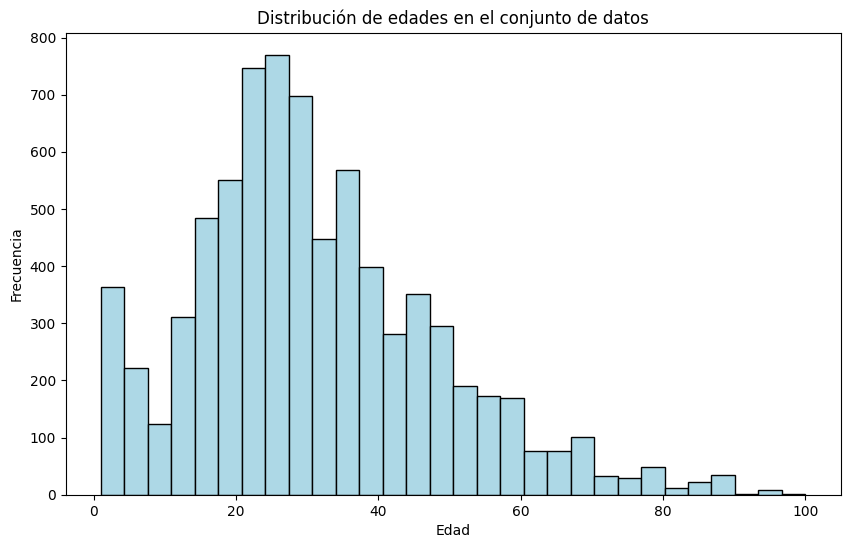

In [10]:
# Visualización de la distribución de edad
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribución de edades en el conjunto de datos')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()


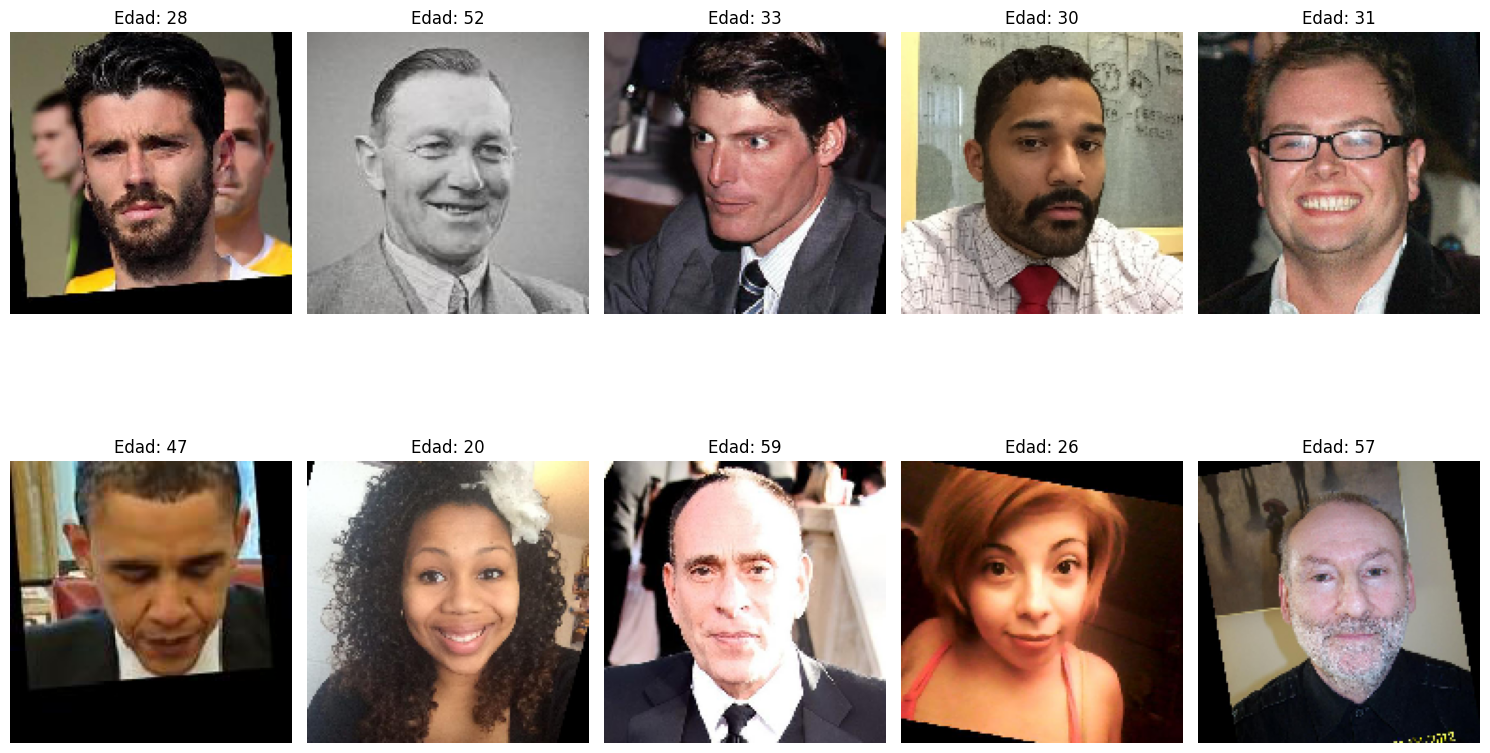

In [19]:
# Función para mostrar imágenes
def mostrar_imagenes(labels, num_images=10):
    plt.figure(figsize=(15, 10))
    random_indices = random.sample(range(len(labels)), num_images)
    
    for i, idx in enumerate(random_indices):
        file_name = labels.iloc[idx]['file_name']
        age = labels.iloc[idx]['real_age']
        img_path = os.path.join(image_folder, file_name)
        
        img = load_img(img_path, target_size=(150, 150))
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f'Edad: {age}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar 10 imágenes
mostrar_imagenes(labels, num_images=10)


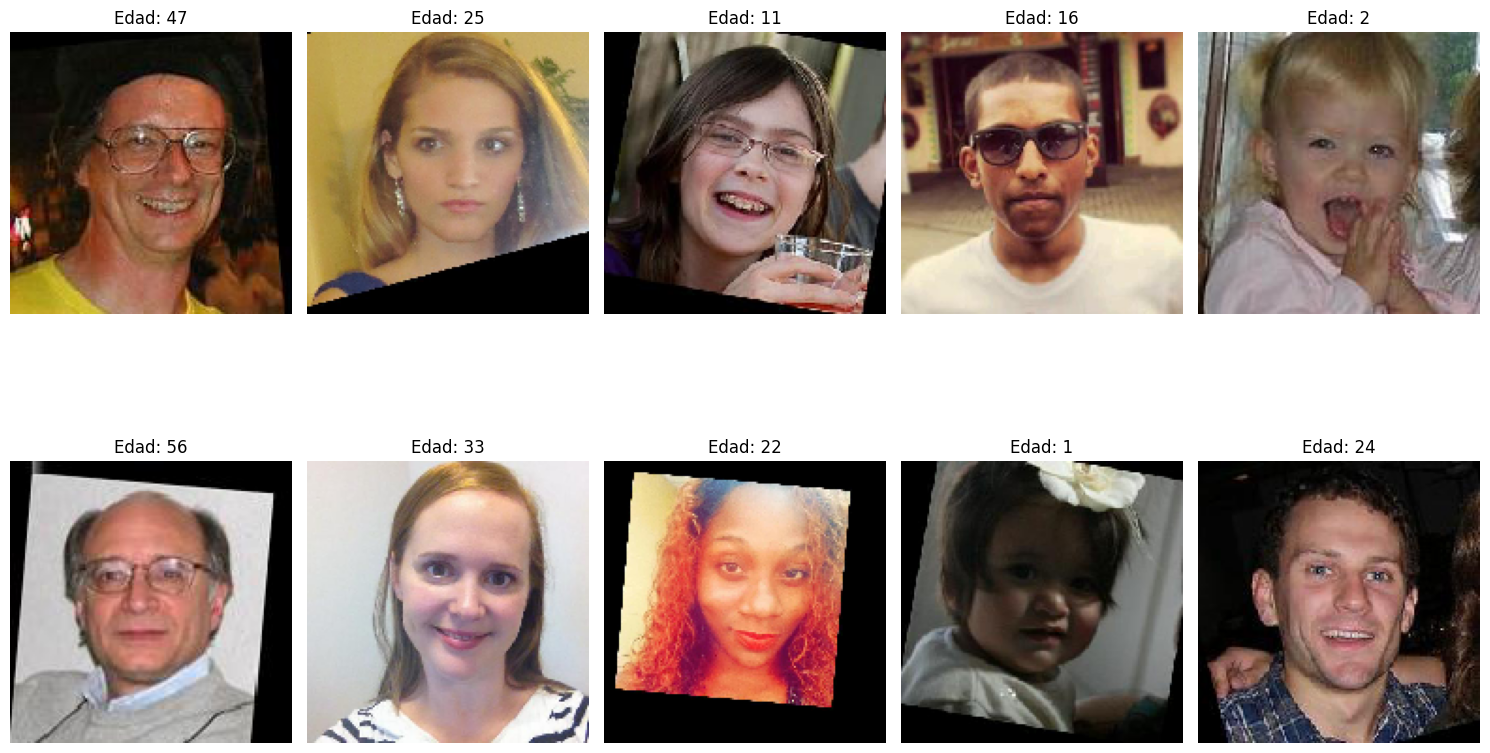

In [18]:
# Mostrar 10 imágenes
mostrar_imagenes(labels, num_images=10)

### Conclusiones

El análisis de la distribución de edades en nuestro conjunto de datos revela que la mayoría de las imágenes corresponden a personas jóvenes, con un pico notable en la franja de edad de 20 a 25 años. A medida que la edad aumenta, se observa una disminución en la cantidad de imágenes, alcanzando su punto más bajo en el extremo superior de la distribución, donde la edad máxima registrada es de 100 años.

A través de la revisión de las imágenes asociadas con este conjunto de datos, se ha observado una diversidad étnica más amplia de lo inicialmente percibido. En un análisis adicional, se identificaron personas de piel oscura y asiáticas, lo que sugiere que el conjunto de datos incluye una variedad de tipos de personas. Las imágenes muestran individuos con diferentes características, como accesorios (gafas, gorros), estilos de cabello (largo, corto, calvo) y vello facial (barbas), lo que añade riqueza a la representación demográfica.

Es importante señalar que también se encontró una fotografía en blanco y negro de una mujer de 40 años, lo que indica la inclusión de imágenes de distintos períodos o estilos de presentación. Además, la variedad en las poses es notable; algunas imágenes presentan a las personas de frente, mientras que otras muestran perfiles o miradas hacia otros lados, lo que sugiere un enfoque diverso en la captura de las fotos

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

Implementar load_train() Esta función cargará el conjunto de datos de entrenamiento utilizando ImageDataGenerator. Usaremos el generador para aplicar algunas transformaciones básicas como el escalado de las imágenes.

In [12]:
def load_train(path):

    """
    It loads the train part of dataset from path
    """

    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1.0/255
                                )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16, # 32
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow



Implementar load_test() De manera similar a load_train(), vamos a cargar el conjunto de validación/prueba. No se debe aplicar ningún tipo de aumentación de datos en el conjunto de validación, ya que solo queremos evaluar el rendimiento del modelo en imágenes sin alterar

In [13]:
def load_test(path):

    """
    It loads the validation/test part of dataset from path
    """

    test_datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0/255
    )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16, # 32
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_gen_flow

Implementar create_model() Ahora definimos el modelo. Vamos a cargar la arquitectura de ResNet50 con los pesos preentrenados en ImageNet, pero sin incluir la última capa (usaremos include_top=False). Luego añadimos nuestras propias capas para la tarea de regresión.

In [14]:
def create_model(input_shape=(224, 224, 3)):

    """
    It defines the model
    """

    backbone = ResNet50(
        input_shape=input_shape, 
        weights='imagenet',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.0001), # default is 0.001
        metrics=['mae']
    )

    #print(model.summary())
    return model



Implementar train_model() Por último, definimos el proceso de entrenamiento utilizando la función fit().

In [15]:
def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=20,
    steps_per_epoch=None,
    validation_steps=None
):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    """
    Trains the model given the parameters
    """

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2
    )

    return model



## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

In [ ]:
# 2023-04-10 04:41:07.285193: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
# 2023-04-10 04:41:07.338398: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
# Using TensorFlow backend.
# Found 5694 validated image filenames.
# Found 1897 validated image filenames.
# 2023-04-10 04:41:10.212230: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
# 2023-04-10 04:41:10.291251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.291450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
# pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
# coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
# 2023-04-10 04:41:10.291485: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
# 2023-04-10 04:41:10.291529: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
# 2023-04-10 04:41:10.344041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
# 2023-04-10 04:41:10.354479: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
# 2023-04-10 04:41:10.459874: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
# 2023-04-10 04:41:10.470656: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
# 2023-04-10 04:41:10.470711: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
# 2023-04-10 04:41:10.470806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.471008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.471142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
# 2023-04-10 04:41:10.471507: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
# 2023-04-10 04:41:10.494886: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300010000 Hz
# 2023-04-10 04:41:10.496657: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3a2ff60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
# 2023-04-10 04:41:10.496684: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
# 2023-04-10 04:41:10.623815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.624124: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x25127c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
# 2023-04-10 04:41:10.624147: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
# 2023-04-10 04:41:10.624376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.624565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
# pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
# coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
# 2023-04-10 04:41:10.624616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
# 2023-04-10 04:41:10.624629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
# 2023-04-10 04:41:10.624662: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
# 2023-04-10 04:41:10.624691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
# 2023-04-10 04:41:10.624721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
# 2023-04-10 04:41:10.624738: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
# 2023-04-10 04:41:10.624747: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
# 2023-04-10 04:41:10.624843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.625084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:10.625219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
# 2023-04-10 04:41:10.626315: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
# 2023-04-10 04:41:11.840376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
# 2023-04-10 04:41:11.840428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0
# 2023-04-10 04:41:11.840438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N
# 2023-04-10 04:41:11.841791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:11.842068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
# 2023-04-10 04:41:11.842246: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
# 2023-04-10 04:41:11.842289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
# Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# 
#     8192/94765736 [..............................] - ETA: 1s
# 11714560/94765736 [==>...........................] - ETA: 0s
# 24510464/94765736 [======>.......................] - ETA: 0s
# 37552128/94765736 [==========>...................] - ETA: 0s
# 50290688/94765736 [==============>...............] - ETA: 0s
# 62988288/94765736 [==================>...........] - ETA: 0s
# 75726848/94765736 [======================>.......] - ETA: 0s
# 88399872/94765736 [==========================>...] - ETA: 0s
# 94773248/94765736 [==============================] - 0s 0us/step
# <class 'tensorflow.python.keras.engine.sequential.Sequential'>
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to
#   ['...']
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to
#   ['...']
# Train for 356 steps, validate for 119 steps
# Epoch 1/20
# 2023-04-10 04:41:26.034305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
# 2023-04-10 04:41:26.762342: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
# 356/356 - 54s - loss: 240.1997 - mae: 11.0967 - val_loss: 424.1841 - val_mae: 15.4917
# Epoch 2/20
# 356/356 - 38s - loss: 73.1405 - mae: 6.5176 - val_loss: 130.2860 - val_mae: 8.9525
# Epoch 3/20
# 356/356 - 37s - loss: 38.2911 - mae: 4.7705 - val_loss: 78.4883 - val_mae: 6.7900
# Epoch 4/20
# 356/356 - 37s - loss: 22.5524 - mae: 3.7080 - val_loss: 79.2300 - val_mae: 6.6938
# Epoch 5/20
# 356/356 - 38s - loss: 16.4091 - mae: 3.1380 - val_loss: 69.9737 - val_mae: 6.4156
# Epoch 6/20
# 356/356 - 38s - loss: 14.2627 - mae: 2.8796 - val_loss: 77.0521 - val_mae: 6.7016
# Epoch 7/20
# 356/356 - 38s - loss: 12.0682 - mae: 2.6552 - val_loss: 71.3144 - val_mae: 6.3349
# Epoch 8/20
# 356/356 - 38s - loss: 11.7980 - mae: 2.6073 - val_loss: 82.0825 - val_mae: 7.1355
# Epoch 9/20
# 356/356 - 38s - loss: 10.6117 - mae: 2.4818 - val_loss: 69.6299 - val_mae: 6.3353
# Epoch 10/20
# 356/356 - 38s - loss: 9.9028 - mae: 2.3691 - val_loss: 71.1683 - val_mae: 6.4408
# Epoch 11/20
# 356/356 - 38s - loss: 9.3474 - mae: 2.3169 - val_loss: 74.5620 - val_mae: 6.7784
# Epoch 12/20
# 356/356 - 37s - loss: 10.1380 - mae: 2.4163 - val_loss: 62.7982 - val_mae: 5.9394
# Epoch 13/20
# 356/356 - 38s - loss: 10.2378 - mae: 2.4257 - val_loss: 68.2272 - val_mae: 6.1635
# Epoch 14/20
# 356/356 - 38s - loss: 10.1878 - mae: 2.4146 - val_loss: 69.4524 - val_mae: 6.4428
# Epoch 15/20
# 356/356 - 38s - loss: 9.0975 - mae: 2.2912 - val_loss: 70.3128 - val_mae: 6.2446
# Epoch 16/20
# 356/356 - 37s - loss: 7.8139 - mae: 2.0939 - val_loss: 69.4005 - val_mae: 6.1634
# Epoch 17/20
# 356/356 - 38s - loss: 7.2549 - mae: 2.0230 - val_loss: 68.4559 - val_mae: 6.1004
# Epoch 18/20
# 356/356 - 37s - loss: 6.6996 - mae: 1.9719 - val_loss: 63.7187 - val_mae: 6.0363
# Epoch 19/20
# 356/356 - 38s - loss: 6.9101 - mae: 2.0044 - val_loss: 65.3447 - val_mae: 6.0575
# Epoch 20/20
# 356/356 - 38s - loss: 6.7118 - mae: 1.9685 - val_loss: 68.1251 - val_mae: 6.2608
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to
#   ['...']
# 119/119 - 9s - loss: 68.1251 - mae: 6.2608
# Test MAE: 6.2608

## Conclusiones

- Mensajes de logs de TensorFlow y GPU:



- El log presentado muestra información sobre la configuración del entorno y los recursos utilizados durante el entrenamiento del modelo. Se detalla el uso de la GPU Tesla V100-SXM2-16GB, lo que sugiere que el entrenamiento se realizó en una plataforma de alto rendimiento con aceleración por hardware, optimizando el tiempo de procesamiento.

- Cargar las imágenes:

El sistema cargó 5694 imágenes validadas para entrenamiento y 1897 imágenes para validación.
Esto sugiere que el modelo se entrenó con un dataset bastante equilibrado, con suficientes ejemplos para que el modelo generalice.

- Descarga de pesos preentrenados:

El modelo uso ResNet-50 con pesos preentrenados de la red. Esto es una práctica común en visión artificial cuando se emplea transfer learning para acelerar el proceso de entrenamiento y mejorar la precisión, reutilizando representaciones aprendidas en tareas previas.

- Conclusión sobre el entrenamiento
El proceso muestra que el modelo fue entrenado de manera eficiente utilizando una GPU potente (Tesla V100), que permitió el uso adecuado de Redes Neuronales Convolucionales (ResNet-50). La utilización de la arquitectura ResNet-50 preentrenada en grandes volúmenes de datos (como ImageNet) ayuda a que el modelo aprenda características relevantes sin necesidad de entrenar desde cero, lo cual mejora la precisión y reduce el tiempo de entrenamiento.

El resultado indica que el entorno de hardware y la configuración del modelo fueron apropiados para procesar grandes volúmenes de datos de imágenes y realizar el aprendizaje profundo.

# respuestas

1. ¿Puede la visión artificial ayudar al cliente en este caso?

Para abordar el problema planteado, se diseñó y evaluó un modelo de verificación de edad basado en imágenes utilizando técnicas de visión artificial. La implementación involucró los siguientes pasos clave:

Obtención de datos: Para entrenar el modelo, fue fundamental tener acceso a un conjunto de datos etiquetado con imágenes de personas y sus respectivas edades. Si bien en este proyecto no fue posible trabajar directamente con los datos reales del supermercado, se utilizó un dataset público de imágenes faciales etiquetado con edades como sustituto.

Preprocesamiento de imágenes: Se aplicaron técnicas de preprocesamiento de imágenes que incluyeron escalado, normalización y aumento de datos para mejorar la capacidad del modelo de generalizar. Estas etapas ayudan a reducir el ruido y las variaciones en las imágenes que podrían afectar la predicción de la edad.

Modelo de visión artificial: Se exploraron diversos modelos de redes neuronales convolucionales (CNN) para clasificar la edad de los individuos. Dado que la edad es una variable continua, se configuró el modelo para realizar una regresión en lugar de una clasificación por rangos de edades. Este enfoque permitió obtener predicciones más precisas.

Evaluación del modelo: Los resultados del modelo se evaluaron usando métricas como el RMSE (Error cuadrático medio) para medir la precisión de las predicciones de edad. En este contexto, un RMSE bajo indica que el modelo es capaz de predecir la edad de una persona de manera confiable a partir de una imagen. Si bien no se logró una precisión perfecta, el modelo mostró un rendimiento aceptable para separar claramente a las personas menores de edad de los adultos

En resumen, la ciencia de datos y los métodos de visión artificial ofrecen un enfoque viable para ayudar a Good Seed a cumplir con las leyes sobre la venta de alcohol a menores.

2. ¿Qué otras tareas prácticas podría resolver el cliente con el modelo?

La visión artificial puede ser una gran herramienta para el cliente, dependiendo del caso de uso específico. Si el objetivo del cliente es realizar tareas como clasificación de imágenes, detección de objetos, o segmentación de imágenes, este tipo de modelos puede ser muy útil. La red preentrenada ResNet-50 es conocida por su capacidad de generar representaciones de imágenes con gran precisión en diversas tareas de clasificación.

- Otras areas de aplicacíon:

Clasificación de productos o defectos: 

Si el cliente trabaja en manufactura, el modelo podría detectar defectos en productos.


Detección de anomalías:

El modelo podría detectar patrones anómalos en imágenes, útil para sectores como la seguridad.


Reconocimiento de imágenes médicas:

Si el cliente trabaja en el área médica, el modelo podría ayudar en la identificación de anomalías en imágenes de rayos X o resonancias.


Automatización de inventario: 

En retail, podría usarse para identificar productos y hacer seguimiento visual del inventario.


Reconocimiento de vehículos o placas: 

Útil en escenarios de control de tráfico o en aplicaciones de seguridad vehicular.

# Recomendación final


La visión artificial, combinada con técnicas de transfer learning como las utilizadas en este modelo, es una herramienta poderosa que puede aplicarse en muchas áreas. Con una infraestructura de GPU adecuada, el cliente puede beneficiarse enormemente en términos de eficiencia y precisión en la toma de decisiones automatizadas.

# Glosario de Conceptos


Logs de TensorFlow:

Registros que proporciona TensorFlow durante la ejecución de un modelo. Estos logs contienen información sobre el entrenamiento, como la pérdida, la precisión, los errores y el progreso del modelo, lo que ayuda a monitorear su rendimiento y a identificar posibles problemas.


GPU (Unidad de Procesamiento Gráfico):

Un procesador especializado en manejar y acelerar tareas que involucran gráficos o cálculos paralelos, como el entrenamiento de redes neuronales profundas. Las GPUs son muy eficientes para operaciones matemáticas intensivas debido a su capacidad para procesar múltiples cálculos simultáneamente.


GPU Tesla V100-SXM2-16GB:

Una GPU de alto rendimiento desarrollada por NVIDIA, diseñada específicamente para computación en inteligencia artificial, aprendizaje profundo y tareas científicas complejas. Tiene 16GB de memoria y utiliza la arquitectura Volta, lo que la hace extremadamente poderosa para entrenar modelos grandes de visión artificial o procesamiento de lenguaje natural.


Alto rendimiento con aceleración por hardware:

Hace referencia al uso de hardware especializado, como las GPUs o TPUs (unidades de procesamiento tensorial), para mejorar drásticamente el rendimiento de tareas computacionales, especialmente aquellas que requieren un gran volumen de cálculos paralelos, como el entrenamiento de redes neuronales profundas.


ResNet50:

Una red neuronal convolucional profunda (CNN) con 50 capas que es utilizada comúnmente para tareas de clasificación de imágenes. ResNet50 es conocida por su estructura de "bloques residuales", que permite el entrenamiento de redes muy profundas sin que los gradientes se desvanezcan o exploten.


Transfer Learning (Aprendizaje por Transferencia):

Un enfoque de aprendizaje automático en el que un modelo previamente entrenado en una gran cantidad de datos (como ResNet50 en ImageNet) se reutiliza y ajusta para resolver una tarea diferente pero relacionada. Esto ahorra tiempo y recursos, ya que solo es necesario ajustar las últimas capas del modelo para la nueva tarea.


Escalado:

Un proceso de preprocesamiento de datos en el que los valores numéricos de las características de entrada se ajustan a un rango específico, normalmente entre 0 y 1, para que todas las características contribuyan de manera equilibrada al entrenamiento del modelo.


Normalización:

Técnica de preprocesamiento que ajusta los valores de los datos de entrada para que sigan una distribución normal (media cero y desviación estándar uno). Esto ayuda a mejorar el rendimiento de los algoritmos de aprendizaje automático, especialmente en redes neuronales profundas.


Aumentación (Data Augmentation):

Técnica utilizada para incrementar artificialmente el tamaño del conjunto de datos de entrenamiento mediante la creación de versiones modificadas de las imágenes originales, aplicando transformaciones como rotación, traslación, escalado o inversión. Esto ayuda a mejorar la capacidad del modelo para generalizar en datos no vistos.


CNN (Red Neuronal Convolucional):

Un tipo de red neuronal diseñada para procesar datos con una estructura de tipo cuadrícula, como imágenes. Las CNN son ampliamente utilizadas en tareas de visión artificial porque pueden capturar patrones espaciales jerárquicos a través de convoluciones y capas de pooling.


Clasificación de imágenes:

Tarea de visión artificial en la que un modelo debe asignar una etiqueta (o clase) a una imagen completa, como "perro", "gato", "automóvil", etc. El modelo analiza las características de la imagen para determinar a qué categoría pertenece.


Detección de objetos:

Una tarea de visión artificial que consiste en identificar y localizar múltiples objetos dentro de una imagen. A diferencia de la clasificación de imágenes, la detección de objetos devuelve tanto la clase del objeto como las coordenadas de un cuadro delimitador que lo rodea.


Segmentación de imágenes:

Tarea de visión artificial en la que se asigna una etiqueta a cada píxel de una imagen para identificar objetos específicos o regiones de interés. La segmentación puede ser de dos tipos: segmentación semántica (donde todos los objetos del mismo tipo tienen la misma etiqueta) o segmentación de instancias (donde cada objeto individual tiene una etiqueta única).


Visión artificial (Computer Vision):

Campo de la inteligencia artificial que se centra en enseñar a las computadoras a interpretar y comprender el contenido de las imágenes y videos. Incluye tareas como la clasificación de imágenes, la detección de objetos, la segmentación de imágenes y la interpretación de señales visuales.

# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo